In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exercise 2: Dimensionality Reduction
- Run "01_run_graphsage_cuda.py" from the exercise folder (or "02_run_graphsage_cpu.py" if you can't use CUDA).
- Reduce graphsage's output to 2D with TSE and visualize the network. Compare a force-directed layout with the TSE layout, and the real labels with graphsage's.


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ADVANCED_NETWORK_SCIENCE/exercise_2')
from graphsage.encoders import Encoder
from graphsage.aggregators import MeanAggregator

sys.path.append('/content/drive/MyDrive/ADVANCED_NETWORK_SCIENCE/exercise_2/cora')


# IMPORTS

In [ ]:
import torch, sys, random
import numpy as np
import pandas as pd
import torch.nn as nn
import networkx as nx
from sklearn.manifold import TSNE
from torch.autograd import Variable
from sklearn.metrics import f1_score
from graphsage.encoders import Encoder
from graphsage.aggregators import MeanAggregator

# DEFINING A SUPERVISED GRAPH SAGE MODEL

- Inputs = number of classes, encoder ('enc')
- Methods = forward to compute node embeddings, loss to calculate cross entropy loss

In [ ]:
class SupervisedGraphSage(nn.Module):
    def __init__(self, num_classes, enc):
        super(SupervisedGraphSage, self).__init__()
        self.enc = enc
        self.xent = nn.CrossEntropyLoss()
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, enc.embed_dim))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, nodes):
        embeds = self.enc(nodes)
        scores = self.weight.mm(embeds)
        return scores.t()

    def loss(self, nodes, labels):
        scores = self.forward(nodes)
        return self.xent(scores, labels.squeeze().to("cuda"))



# LOADING THE CORA DATASET (data, labels, graph structure)

- In addition, the function turns the df into an adjacency list of the graph
- And returns feature data (feat_data), labels (labels), adjacency lists (adj_lists) and a mapping of the nodes IDs to indices (node_map)

In [ ]:
def load_cora():
   df = pd.read_csv("/content/drive/MyDrive/ADVANCED_NETWORK_SCIENCE/exercise_2/cora/cora.content", sep = "\t", header = None)
   feat_data = df.values[:,1:-1].astype(float)
   labels = pd.factorize(df.iloc[:,-1])[0]
   node_map = df.reset_index().set_index(0)["index"].to_dict()
   G = nx.read_edgelist("/content/drive/MyDrive/ADVANCED_NETWORK_SCIENCE/exercise_2/cora/cora.cites", nodetype = int)
   adj_lists = {}
   for n in G.nodes():
      adj_lists[node_map[n]] = {node_map[n2] for n2 in G.neighbors(n)}
   return feat_data, labels, adj_lists, {node_map[n]: n for n in node_map}

feat_data, labels, adj_lists, node_map = load_cora()

# nn.Embedding module to create an embedding layer

In [ ]:
features = nn.Embedding(feat_data.shape[0], feat_data.shape[1])
features.weight = nn.Parameter(torch.FloatTensor(feat_data), requires_grad = False)
features.cuda()

Embedding(2708, 1433)

# Initializing aggregator and encoder

This is a key aspect for aggregating info from neighboring nodes in the graph

In [ ]:
agg1 = MeanAggregator(features, cuda = True)
enc1 = Encoder(features, feat_data.shape[1], 128, adj_lists, agg1, gcn = True, cuda = True)
agg2 = MeanAggregator(lambda nodes : enc1(nodes).t(), cuda = True)
enc2 = Encoder(lambda nodes : enc1(nodes).t(), enc1.embed_dim, 128, adj_lists, agg2, base_model = enc1, gcn = True, cuda = True)
enc1.num_samples = 5
enc2.num_samples = 5

# Training

- Randomly select a batch of training nodes
- Compute the loss (predictions vs true labels)
- Perform backpropagation using SGD

In [ ]:
graphsage = SupervisedGraphSage(len(set(labels)), enc2)
graphsage.cuda()
rand_indices = np.random.permutation(feat_data.shape[0])
test = rand_indices[:1000]
val = rand_indices[1000:1500]
train = list(rand_indices[1500:])

optimizer = torch.optim.SGD(filter(lambda p : p.requires_grad, graphsage.parameters()), lr = 0.7)
for batch in range(100):
   batch_nodes = train[:256]
   random.shuffle(train)
   optimizer.zero_grad()
   loss = graphsage.loss(batch_nodes, Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
   loss.backward()
   optimizer.step()
   sys.stderr.write(f"Batch {batch}, Loss {loss.data.item()}\n")

Batch 0, Loss 1.952295184135437
Batch 1, Loss 1.9352855682373047
Batch 2, Loss 1.91193687915802
Batch 3, Loss 1.9007364511489868
Batch 4, Loss 1.8764803409576416
Batch 5, Loss 1.8463865518569946
Batch 6, Loss 1.8262172937393188
Batch 7, Loss 1.7718112468719482
Batch 8, Loss 1.7296087741851807
Batch 9, Loss 1.68374502658844
Batch 10, Loss 1.5935916900634766
Batch 11, Loss 1.5635685920715332
Batch 12, Loss 1.4944427013397217
Batch 13, Loss 1.4673974514007568
Batch 14, Loss 1.3458398580551147
Batch 15, Loss 1.3293856382369995
Batch 16, Loss 1.2759342193603516
Batch 17, Loss 1.2064114809036255
Batch 18, Loss 1.1582565307617188
Batch 19, Loss 1.0613672733306885
Batch 20, Loss 1.0323033332824707
Batch 21, Loss 0.905068576335907
Batch 22, Loss 0.7899905443191528
Batch 23, Loss 0.8629967570304871
Batch 24, Loss 0.8089569807052612
Batch 25, Loss 0.7426594495773315
Batch 26, Loss 0.7881369590759277
Batch 27, Loss 0.8662506341934204
Batch 28, Loss 0.9525054097175598
Batch 29, Loss 0.9556543231010

# F1 Evaluation

In [ ]:
val_output = graphsage.forward(val)
sys.stderr.write(f"Validation F1: {f1_score(labels[val], val_output.data.cpu().numpy().argmax(axis = 1), average = 'micro')}\n")

test_output = graphsage.forward(test)
sys.stderr.write(f"Test F1: {f1_score(labels[test], test_output.data.cpu().numpy().argmax(axis = 1), average = 'micro')}\n")

Validation F1: 0.85
Test F1: 0.854


In [ ]:
val_output[0] # predictions on val set

tensor([ 1.1787, -1.0100, -1.5004,  9.3750, -0.8104, -3.4951, -3.9553],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
full_output = graphsage.forward(range(features.num_embeddings))

In [ ]:
full_output[0] # output for one specific node

tensor([ 7.4455, -2.3851, -2.0295,  1.2821, -0.0447, -1.7659, -2.5669],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
full_output[0] # output for one specific node
output_embedded = TSNE(n_components=2).fit_transform(full_output.cpu().data.numpy())

# nodes = test, val, train?
# edges = citations?
# communities = based on outputs probabilities

In [ ]:
output_embedded.shape

(2708, 2)

The goal is to take in the initial network, feed the embeddings of each node into the neural network, get predictions (tensor of 6 numbers) and reduce the dimensionality of these outputs to just 2 dimensions. With these 2 dimension tensors, the goal is to replicate the initial graph but with nodes closer to each other if predicted to be 'similar', and far away if predicted to not be similar based on the initial embeddings.

In [ ]:
G = nx.read_edgelist("/content/drive/MyDrive/ADVANCED_NETWORK_SCIENCE/exercise_2/cora/cora.cites", nodetype = int)
len(G.edges)

5278

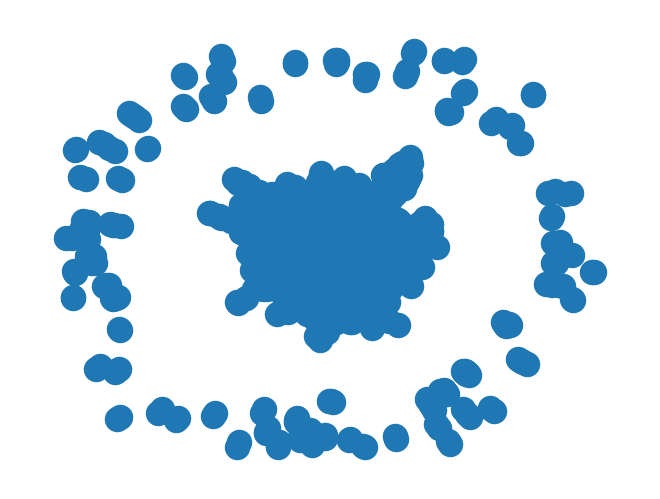

In [ ]:
nx.draw(G)

NetworkXError: ignored

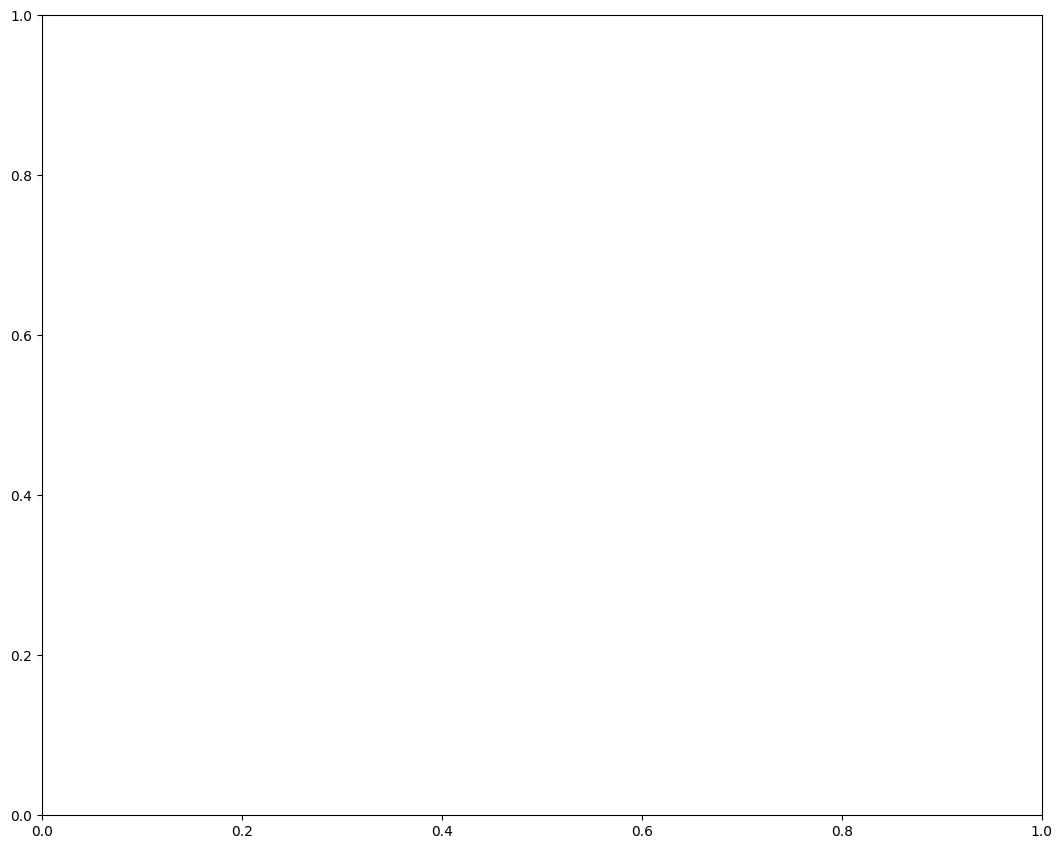

In [ ]:
pos = {node_id: (x, y) for node_id, (x, y) in enumerate(output_embedded)}
plt.figure(figsize=(10, 8))
nx.draw(G, pos=pos, with_labels=True, node_size=100, font_size=10, font_color='black')
plt.title('Graph with Updated Node Positions')
plt.show()


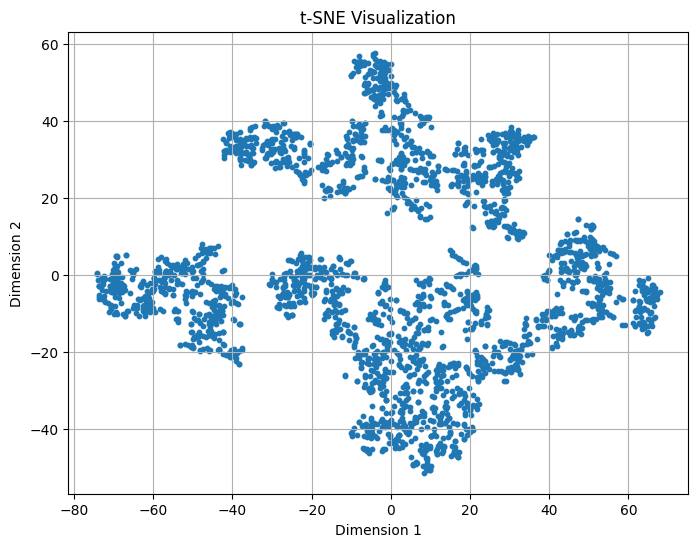

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(output_embedded[:, 0], output_embedded[:, 1], marker='o', s=10)
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

# PART 2

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [ ]:
feat_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(feat_data)

In [ ]:
X_embedded.shape

(2708, 2)

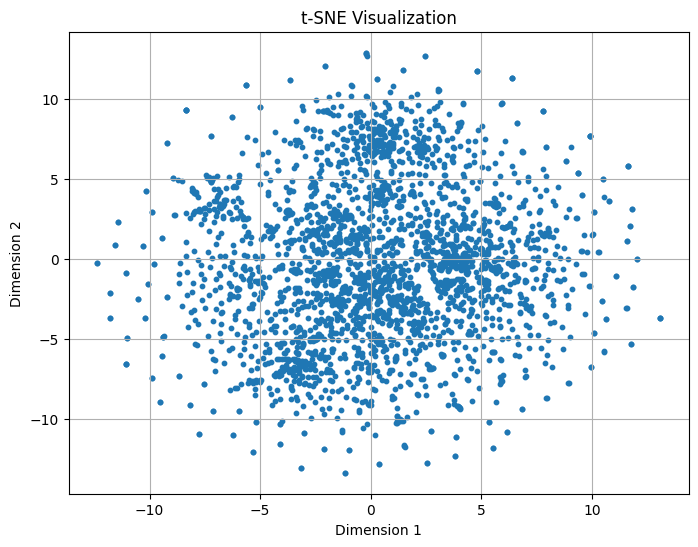

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', s=10)
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()